#### SECTION B

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import scipy.optimize as opt
from scipy.stats import chi2

import random
import os
import time
from IPython.display import display
from imblearn.over_sampling import SMOTE

---

#### <small>1. Variables Related to \( B_s^0 \) (Mother Particle)</small>
| **Feature Name**                   | **Description** |
|-------------------------------------|----------------------------------------------------------------|
| `Bs_PX`, `Bs_PY`, `Bs_PZ`          | Momentum components (x, y, z) of the \( B_s^0 \) candidate. |
| `Bs_E`, `Bs_P`, `Bs_PT`            | Energy, total momentum, and transverse momentum \( p_T \). |
| `Bs_M`                             | Mass of the \( B_s^0 \) candidate (used for background selection, not ML). |
| `Bs_ImpactParameter`, `Bs_ImpactParameter_Chi2` | Impact parameter (IP) of the \( B_s^0 \) with respect to the primary vertex, and its \( \chi^2 \) goodness-of-fit. Lower values mean better vertex reconstruction. |
| `Bs_FlightDistance`, `Bs_FlightDistance_Chi2` | Distance the \( B_s^0 \) traveled before decaying, and its corresponding \( \chi^2 \) fit quality. Longer distances indicate real \( B_s^0 \) decays. |
| `Bs_ProductionVertex_X,Y,Z` | 3D coordinates of the \( B_s^0 \)'s production vertex (where it was created). |
| `Bs_DecayVertex_X,Y,Z` | 3D coordinates of the \( B_s^0 \)'s decay vertex (where it decayed). |
| `Bs_CosMomentumDecayAngle` | Cosine of the angle between the \( B_s^0 \) momentum vector and the vector joining its production and decay vertices. **Signal events have values close to 1 (aligned motion).** |

---

#### <small>2. Variables Related to \( D_s^\mp \) (Intermediate Particle)</small>
| **Feature Name** | **Description** |
|-----------------|----------------------------------------------------------------|
| `Ds_PX`, `Ds_PY`, `Ds_PZ` | Momentum components (x, y, z) of the \( D_s^\mp \) meson. |
| `Ds_E`, `Ds_P`, `Ds_PT`, `Ds_M` | Energy, momentum, transverse momentum \( p_T \), and mass of the \( D_s^\mp \). |
| `Ds_ImpactParameter`, `Ds_ImpactParameter_Chi2` | Impact parameter of the \( D_s^\mp \) and its \( \chi^2 \) fit quality. |
| `Ds_FlightDistance`, `Ds_FlightDistance_Chi2` | Distance the \( D_s^\mp \) traveled before decaying. |
| `Ds_DecayVertex_X,Y,Z` | 3D decay vertex coordinates of the \( D_s^\mp \). |
| `Ds_CosMomentumDecayAngle` | Cosine of the angle between the \( D_s^\mp \) momentum and its decay vertex displacement vector. |
| `Ds_CosAngleToBs` | Cosine of the angle between the \( D_s^\mp \) and \( B_s^0 \) momenta. |

---

#### <small>3. Variables Related to Companion Pion (\( \pi^\pm \) from \( B_s^0 \) decay)</small>
| **Feature Name** | **Description** |
|-----------------|----------------------------------------------------------------|
| `Pi_PX`, `Pi_PY`, `Pi_PZ` | Momentum components (x, y, z) of the companion pion from the \( B_s^0 \) decay. |
| `Pi_E`, `Pi_P`, `Pi_PT`, `Pi_M` | Energy, momentum, transverse momentum \( p_T \), and mass of the pion. |
| `Pi_ImpactParameter`, `Pi_ImpactParameter_Chi2` | Impact parameter and \( \chi^2 \) fit quality of the pion. |
| `Pi_TrackFit_Chi2pDOF` | Track fit quality for the pion. Lower values mean a better track reconstruction. |
| `Pi_ProbNNk, Pi_ProbNNpi, Pi_ProbNNp` | Probability that the particle is a **kaon, pion, or proton** based on machine learning classification from the detector. |
| `Pi_CosAngleToBs` | Cosine of the angle between the pion's momentum and the \( B_s^0 \) momentum. |

---

#### <small>4. Variables Related to \( D_s^\mp \) Decay Products: \( K^+ K^- \pi^\mp \)</small>
| **Feature Name** | **Description** |
|-----------------|----------------------------------------------------------------|
| `Ds_K1_PX`, `Ds_K1_PY`, `Ds_K1_PZ` | Momentum components of the first kaon. |
| `Ds_K2_PX`, `Ds_K2_PY`, `Ds_K2_PZ` | Momentum components of the second kaon. |
| `Ds_Pi_PX`, `Ds_Pi_PY`, `Ds_Pi_PZ` | Momentum components of the pion from \( D_s^\mp \) decay. |
| `Ds_K1_P`, `Ds_K1_PT`, `Ds_K1_E` | Momentum, transverse momentum \( p_T \), and energy of the first kaon. |
| `Ds_K2_P`, `Ds_K2_PT`, `Ds_K2_E` | Momentum, transverse momentum \( p_T \), and energy of the second kaon. |
| `Ds_Pi_P`, `Ds_Pi_PT`, `Ds_Pi_E` | Momentum, transverse momentum \( p_T \), and energy of the pion from \( D_s^\mp \) decay. |
| `Ds_K1_ImpactParameter`, `Ds_K1_ImpactParameter_Chi2` | Impact parameter and \( \chi^2 \) fit quality of the first kaon. |
| `Ds_K2_ImpactParameter`, `Ds_K2_ImpactParameter_Chi2` | Impact parameter and \( \chi^2 \) fit quality of the second kaon. |
| `Ds_Pi_ImpactParameter`, `Ds_Pi_ImpactParameter_Chi2` | Impact parameter and \( \chi^2 \) fit quality of the pion from \( D_s^\mp \) decay. |
| `Ds_K1_ProbNNk, Ds_K1_ProbNNpi, Ds_K1_ProbNNp` | Probability that the first kaon is a **kaon, pion, or proton**. |
| `Ds_K2_ProbNNk, Ds_K2_ProbNNpi, Ds_K2_ProbNNp` | Probability that the second kaon is a **kaon, pion, or proton**. |
| `Ds_Pi_ProbNNk, Ds_Pi_ProbNNpi, Ds_Pi_ProbNNp` | Probability that the pion is a **kaon, pion, or proton**. |


Each row repersent different events producing particles idenpendently through different decay events of heavier particles

The decay process you mentioned:

\[
B_s^0 \to D_s^- \pi^+
\]

with the subsequent decay:

\[
D_s^- \to K^+ K^- \pi^-
\]


1. **Parent Particle: \( B_s^0 \) (Strange B Meson)**
   - Composed of a bottom (\( b \)) antiquark and a strange (\( s \)) quark (\( \bar{b}s \)).
   - It undergoes weak decay via the **charged-current interaction**.

2. **Intermediate State: \( D_s^- \) (Strange D Meson)**
   - Composed of a charm (\( c \)) quark and a strange (\( \bar{s} \)) antiquark (\( c\bar{s} \)).
   - It is a key meson in studying charm decays and CP violation.

3. **Final State Particles:**
   - One **charged pion** (\( \pi^+ \)).
   - One **charged kaon pair** (\( K^+ K^- \)) and a **charged pion** (\( \pi^- \)) from the \( D_s^- \) decay.

--------------------------------------------------------------------------------
B-Meson Bkg mean-std: 
6205.089374733743 395.4313591859284
--------------------------------------------------------------------------------
Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298317 entries, 0 to 298316
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Bs_P                      298317 non-null  float64
 1   Bs_PT                     298317 non-null  float64
 2   Bs_FlightDistance         298317 non-null  float64
 3   Bs_FlightDistance_Chi2    298317 non-null  float64
 4   Bs_ImpactParameter        298317 non-null  float64
 5   Bs_ImpactParameter_Chi2   298317 non-null  float64
 6   Bs_CosMomentumDecayAngle  298317 non-null  float64
 7   Ds_P                      298317 non-null  float64
 8   Ds_PT                     298317 non-null  float64
 9   Ds_ImpactParameter        298317 non-null 

None

Signal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187284 entries, 0 to 187283
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Bs_P                      187284 non-null  float64
 1   Bs_PT                     187284 non-null  float64
 2   Bs_FlightDistance         187284 non-null  float64
 3   Bs_FlightDistance_Chi2    187284 non-null  float64
 4   Bs_ImpactParameter        187284 non-null  float64
 5   Bs_ImpactParameter_Chi2   187284 non-null  float64
 6   Bs_CosMomentumDecayAngle  187284 non-null  float64
 7   Ds_P                      187284 non-null  float64
 8   Ds_PT                     187284 non-null  float64
 9   Ds_ImpactParameter        187284 non-null  float64
 10  Ds_ImpactParameter_Chi2   187284 non-null  float64
 11  Ds_CosMomentumDecayAngle  187284 non-null  float64
 12  Ds_CosAngleToBs           187284 non-null  float64
 13  Pi_P                      187284 non-

None

------------------------------------------------------------
Background
<class 'pandas.core.frame.DataFrame'>
Index: 97181 entries, 4 to 298316
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Bs_P                      97181 non-null  float64
 1   Bs_PT                     97181 non-null  float64
 2   Bs_FlightDistance         97181 non-null  float64
 3   Bs_FlightDistance_Chi2    97181 non-null  float64
 4   Bs_ImpactParameter        97181 non-null  float64
 5   Bs_ImpactParameter_Chi2   97181 non-null  float64
 6   Bs_CosMomentumDecayAngle  97181 non-null  float64
 7   Ds_P                      97181 non-null  float64
 8   Ds_PT                     97181 non-null  float64
 9   Ds_ImpactParameter        97181 non-null  float64
 10  Ds_ImpactParameter_Chi2   97181 non-null  float64
 11  Ds_CosMomentumDecayAngle  97181 non-null  float64
 12  Ds_CosAngleToBs           97181 non-null  float6

None

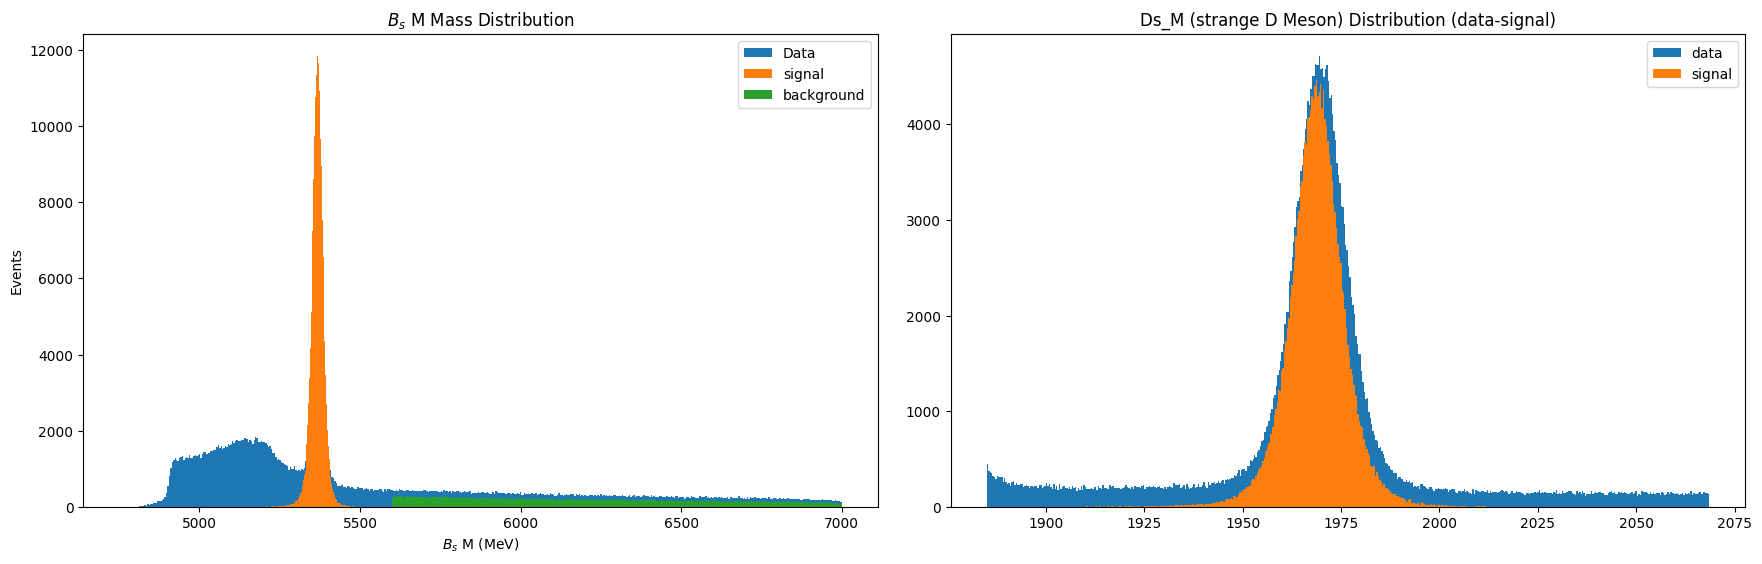

In [137]:
# Paths to the ROOT files (Update these paths if needed)
signal_file = "data/sec_b/MC.root"
data_file = "data/sec_b/data.root"

def load_root_file(file_path, tree_name="DecayTree", variables=None):
    """Load a ROOT file and return a Pandas DataFrame with selected variables."""
    with uproot.open(file_path) as file:
        tree = file[tree_name]
        df = tree.arrays(variables, library="pd")
    return df

# Define variables to use (avoiding direct use of mass to prevent bias)
variables = [
    "Bs_P", "Bs_PT", "Bs_FlightDistance", "Bs_FlightDistance_Chi2", "Bs_ImpactParameter", "Bs_ImpactParameter_Chi2",
    "Bs_CosMomentumDecayAngle", "Ds_P", "Ds_PT", "Ds_ImpactParameter", "Ds_ImpactParameter_Chi2",
    "Ds_CosMomentumDecayAngle", "Ds_CosAngleToBs", "Pi_P", "Pi_PT", "Pi_ImpactParameter_Chi2",
    "Pi_CosAngleToBs", "Bs_M", "Ds_M"  # Mass used only for background selection, not training
]

# Load signal and data
signal_df = load_root_file(signal_file, variables=variables)
data_df = load_root_file(data_file, variables=variables)

# Define Signal: The entire Monte Carlo dataset
signal_df["label"] = 1  # Signal class label

# Define Background: Events where Bs_M > 5600 MeV (far from signal peak)
background_df = data_df[data_df["Bs_M"] > 5600].copy()
background_df["label"] = 0  # Background class label

fig, axs = plt.subplots(1, 2, figsize = (18, 6)) 

axs[0].hist(data_df['Bs_M'], label = 'Data', bins = 500)
axs[0].hist(signal_df['Bs_M'], label = 'signal', bins = 500)
axs[0].hist(background_df['Bs_M'], label = 'background', bins = 500)
axs[0].set_title('$B_s$ M Mass Distribution')
axs[0].set_xlabel('$B_s$ M (MeV)')
axs[0].set_ylabel('Events')


axs[1].hist(data_df['Ds_M'], label = 'data', bins = 500)
axs[1].hist(signal_df['Ds_M'], label = 'signal', bins = 500)
axs[1].set_title('Ds_M (strange D Meson) Distribution (data-signal)')


axs[0].legend()
axs[1].legend()

print('----' * 20)
print('B-Meson Bkg mean-std: ')
print(background_df['Bs_M'].mean(), background_df['Bs_M'].std())
print('----' * 20)


# Drop the mass variable before training to prevent bias
signal_df.drop(columns=["Bs_M", "Ds_M"], inplace=True)
background_df.drop(columns=["Bs_M", "Ds_M"], inplace=True)

# data_df.drop(columns=["Bs_M"], inplace=True)

print('Data')
display(data_df.info())


print('Signal')
display(signal_df.info())

print('---' * 20)

print('Background')
display(background_df.info())

# # Merge signal and background into one dataset
# dataset = pd.concat([signal_df, background_df], ignore_index=True)

# # Shuffle dataset
# dataset = dataset.sample(frac=1).reset_index(drop=True)

plt.tight_layout(pad = 2)
plt.show()

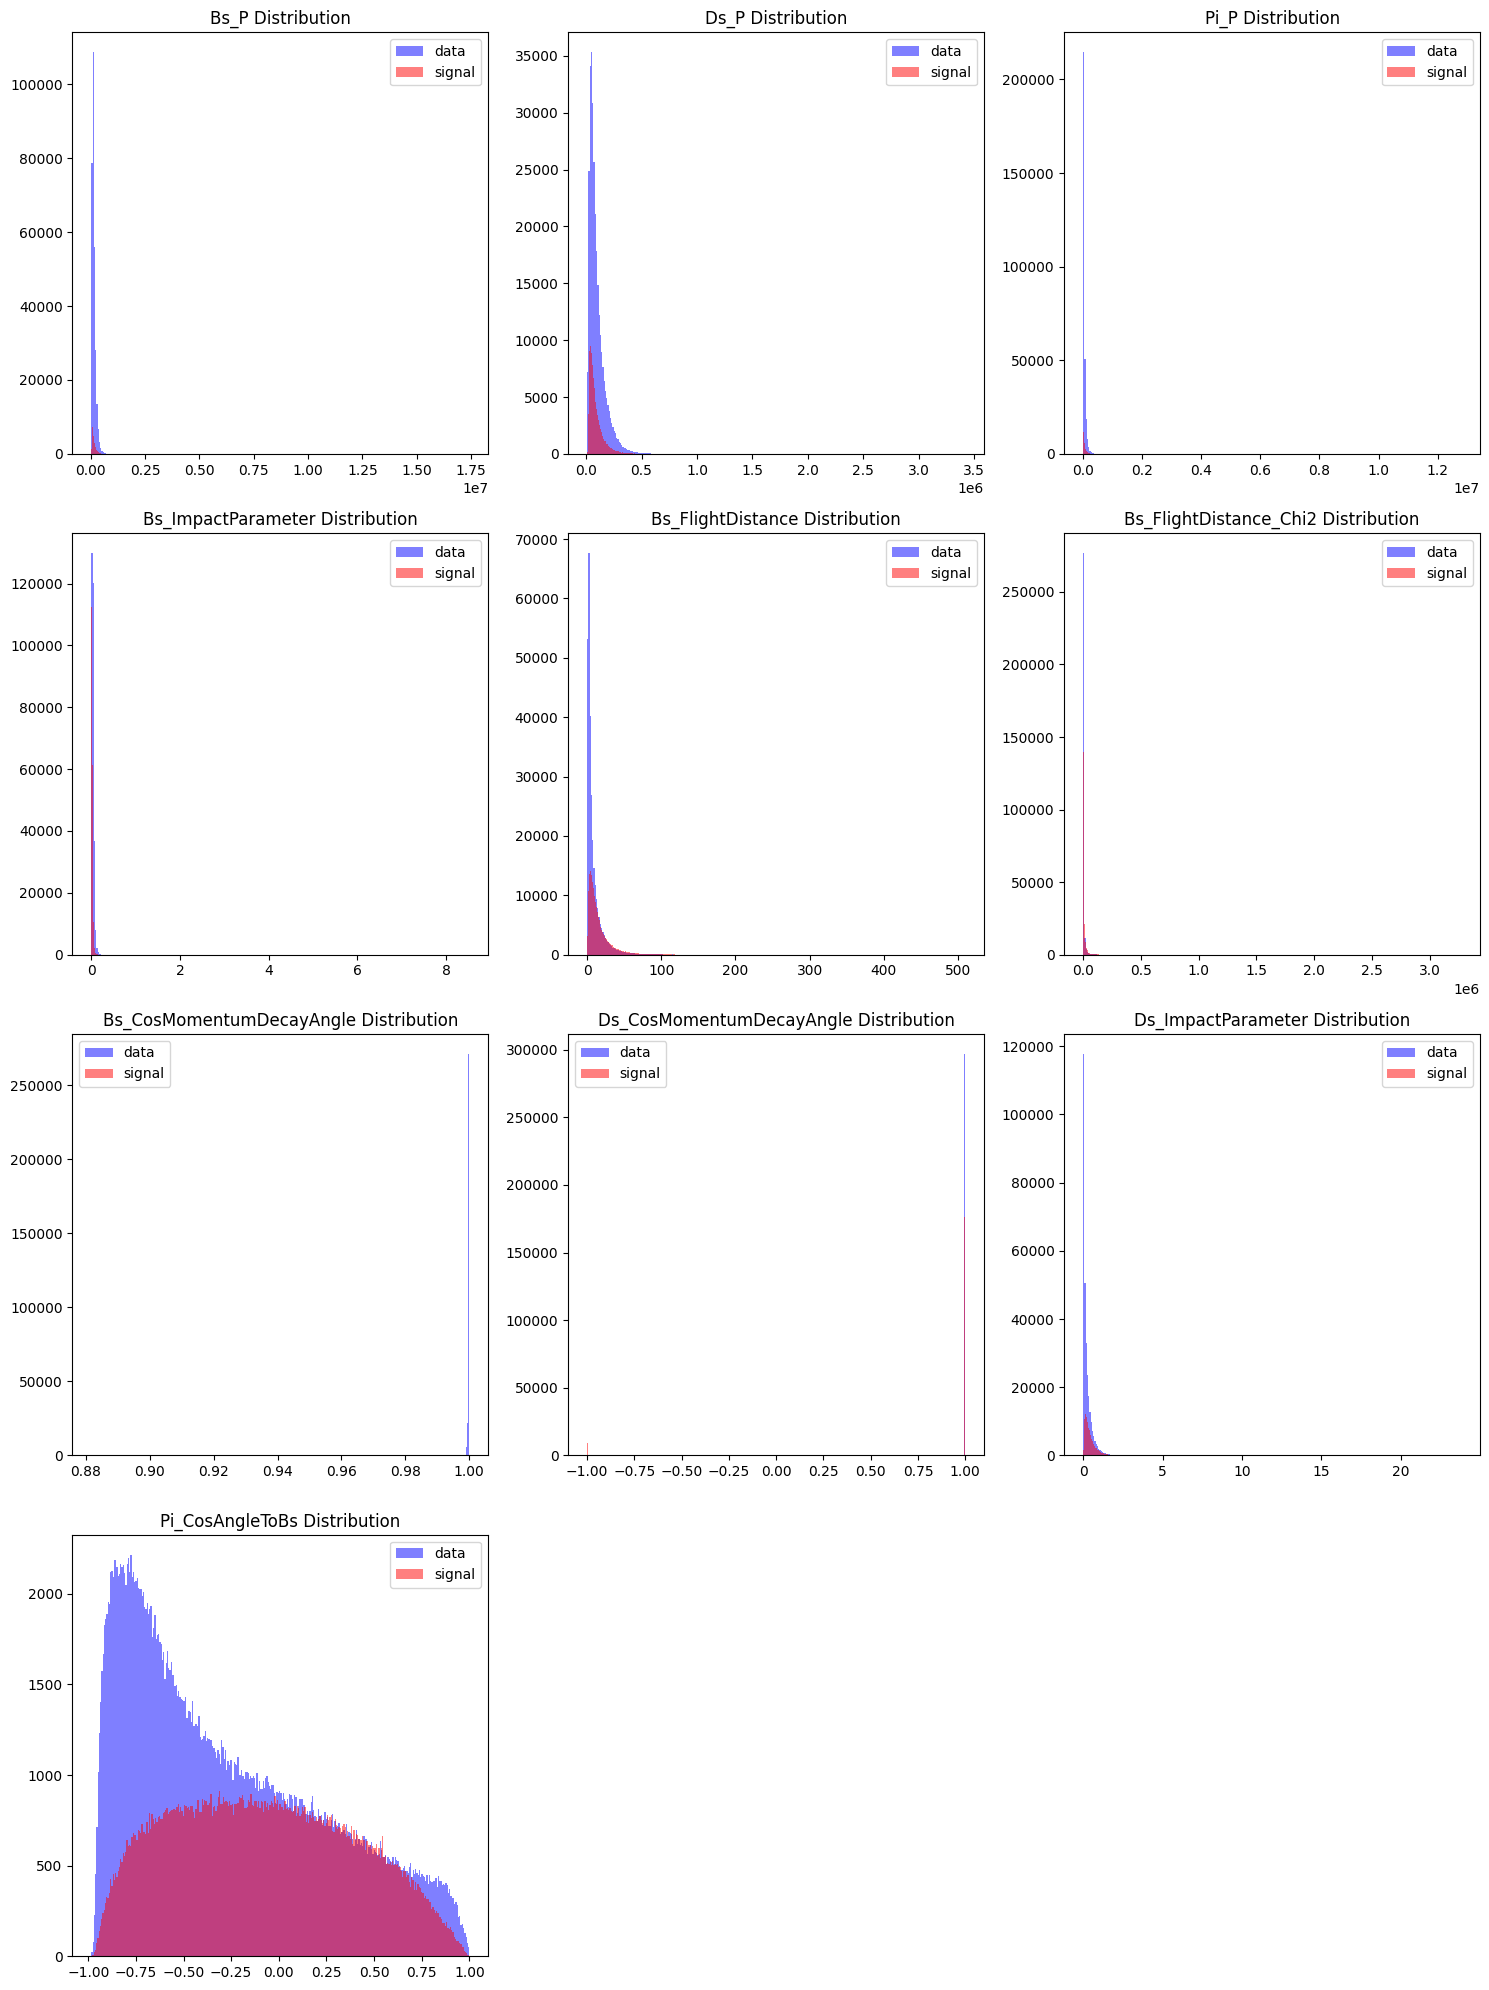

In [8]:
plots_variables = [
    "Bs_P", "Ds_P", "Pi_P", "Bs_ImpactParameter",
    "Bs_FlightDistance", "Bs_FlightDistance_Chi2", "Bs_CosMomentumDecayAngle",
    "Ds_CosMomentumDecayAngle", "Ds_ImpactParameter", "Pi_CosAngleToBs"
]

# Define number of rows and columns for subplots
ncols = 3
nrows = 4  # Adjust to have 4 rows for 10 plots

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))  # Adjust size based on rows
axs = axs.flatten()  # Flatten in case of multiple rows

for i, var in enumerate(plots_variables):
    if var in data_df.columns and var in signal_df.columns:
        axs[i].hist(data_df[var], bins=300, alpha=0.5, label="data", color="blue")
        axs[i].hist(signal_df[var], bins=300, alpha=0.5, label="signal", color="red")
        axs[i].set_title(f"{var} Distribution")
        axs[i].legend()
    else:
        print(var)
        axs[i].set_visible(False)  # Hide unused subplots if the number of variables is not a multiple of 3

# Hide any extra subplots (in case of a 12-plot grid)
for j in range(len(plots_variables), len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()


In [9]:
# Print information about the datasets 
print(f"Signal samples: {len(signal_df)}")
print(f"Background samples: {len(background_df)}")
print(f"Data samples: {len(data_df)}") ## Signal + Background Data


# Check if any features are missing in our datasets
missing_in_signal = [f for f in variables if f not in signal_df.columns]
missing_in_bg = [f for f in variables if f not in background_df.columns]
missing_in_data = [f for f in variables if f not in data_df.columns]

if missing_in_signal or missing_in_bg or missing_in_data:
    print(f"Missing features in signal: {missing_in_signal}")
    print(f"Missing features in background: {missing_in_bg}")
    print(f"Missing features in data: {missing_in_data}")
    # Adjust features list if needed
    variables = [f for f in variables if f in signal_df.columns and f in background_df.columns and f in data_df.columns]

Signal samples: 187284
Background samples: 97181
Data samples: 298317
Missing features in signal: ['Bs_M', 'Ds_M']
Missing features in background: ['Bs_M', 'Ds_M']
Missing features in data: []


(199125, 17) (199125,) (85340, 17) (85340,)
bkg-samples-num:  67957 , signal-samples-num:  131168


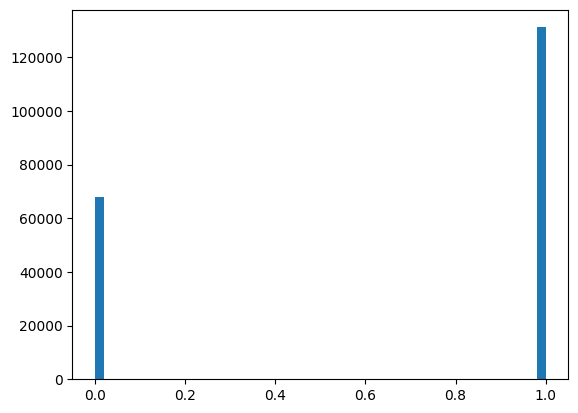

In [117]:
# Prepare the training data
X_signal = signal_df[variables]
X_background = background_df[variables]

y_signal = np.ones(len(X_signal))
y_background = np.zeros(len(X_background))

X = pd.concat([X_signal, X_background])
y = np.concatenate([y_signal, y_background]) ## Signal/Background binary classif

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print('bkg-samples-num: ', len(y_train[y_train == 0]), ', signal-samples-num: ', len(y_train[y_train == 1]))
plt.hist(y_train, bins=50)
plt.show()

In [118]:
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_train, y_train = smote.fit_resample(X_train, y_train)  # Resampling

# Shuffle the data
train_indices = np.random.permutation(len(y_train))
X_train, y_train = X_train[train_indices], y_train[train_indices]

# Check the new shapes and class distribution
print(X_train.shape, y_train.shape)
print('bkg-samples-num: ', len(y_train[y_train == 0]), ', signal-samples-num: ', len(y_train[y_train == 1]))

(262336, 17) (262336,)
bkg-samples-num:  131168 , signal-samples-num:  131168


time-taken:  0.2463422934214274  mins


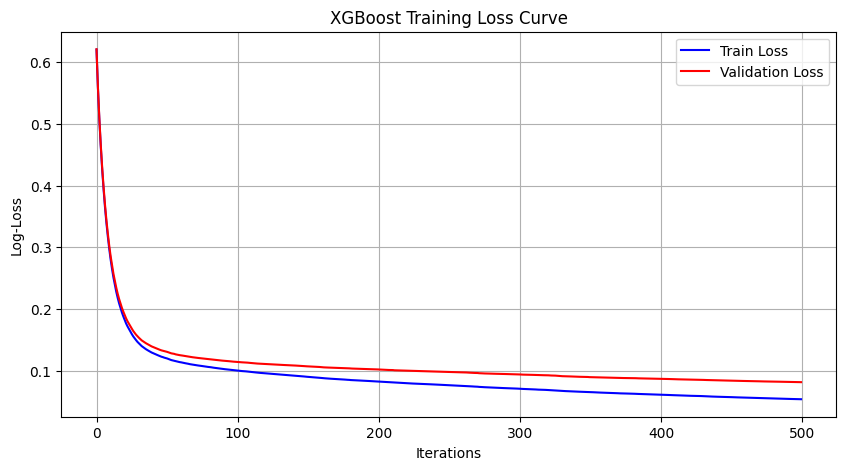

In [119]:
# Define model with evaluation metric
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'  # Track log-loss during training
)

# Train the model while tracking the log-loss
eval_set = [(X_train, y_train), (X_test, y_test)]  # Training and validation set
ft = time.time()
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
lt = time.time()

print('time-taken: ', (lt - ft)/60, ' mins')

# Retrieve log-loss values
results = model.evals_result()

# Plot training vs validation loss curve
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['logloss'], label='Train Loss', color='blue')
plt.plot(results['validation_1']['logloss'], label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log-Loss')
plt.title('XGBoost Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

# Get feature importances
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]


,Bs_P,Bs_PT,Bs_FlightDistance,Bs_FlightDistance_Chi2,Bs_ImpactParameter,Bs_ImpactParameter_Chi2,Bs_CosMomentumDecayAngle,Ds_P,Ds_PT,Ds_ImpactParameter,Ds_ImpactParameter_Chi2,Ds_CosMomentumDecayAngle,Ds_CosAngleToBs,Pi_P,Pi_PT,Pi_ImpactParameter_Chi2,Pi_CosAngleToBs,Bs_M,Ds_M,bdt_score
0,144842.497583,5647.651673,6.337716,790.981990,0.038635,10.302347,0.999981,132885.639958,6595.140361,0.033327,7.472162,1.000000,0.812132,12047.560659,953.363621,671.928064,-0.812120,5560.817,1963.963,0.093307
1,61506.458251,8687.239953,2.877930,807.021782,0.037426,12.957003,0.999915,29554.201206,6121.759544,0.215361,289.236567,0.999983,-0.217011,32092.105248,2773.884501,264.685076,0.216465,5059.540,1926.662,0.647436
2,457496.620616,10776.534323,43.899856,3860.506320,0.018533,1.380054,1.000000,334577.098781,6108.036762,0.259596,217.748662,1.000000,0.367904,122972.083797,4744.078698,1891.619566,-0.368443,4860.016,1888.828,0.999522
3,131414.524659,17324.326448,14.373980,21755.236603,0.016070,2.674008,0.999999,122060.456533,15890.424749,0.154280,232.442807,1.000000,0.833058,9435.156251,1876.257640,11130.298839,-0.832981,5062.393,1983.172,0.999342
4,224883.192585,5666.514289,7.546324,2375.874176,0.038601,5.216225,0.999987,211413.307315,5913.037596,0.027732,2.166474,1.000000,0.867839,13546.637006,1322.983690,1976.002676,-0.867794,6218.439,1958.407,0.017103


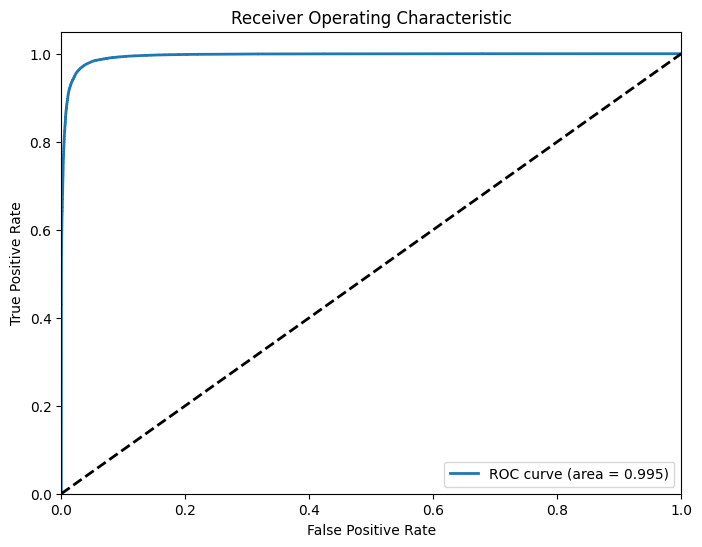

In [120]:
# Make predictions on test set
y_pred = model.predict_proba(X_test)[:, 1]

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Apply the model to the real data
data_predictions = model.predict_proba(data_df[variables])[:, 1]
data_df['bdt_score'] = data_predictions

display(data_df.head())

In [43]:
# from sklearn.metrics import roc_curve, auc

# # make roc curve (use test sample)
# fpr, tpr, thresholds = roc_curve( y_test, model.predict_proba(X_test)[:,1])
# roc_auc = auc(fpr, tpr)
# print("AUC = ", roc_auc)
# plt.plot( tpr, 1-fpr, lw=1 )
# plt.xlabel( "Signal Efficiency" )
# plt.ylabel( "Background Rate" )

# # plot cut efficiency (use total sample)
# bdt_score = np.array(list(data_df['bdt_score'].values))
# label = np.concatenate([signal_df['label'], background_df['label']])
# sorted_indices = np.argsort( bdt_score )
# sorted_scores = bdt_score[ sorted_indices ]
# sorted_labels = label[ sorted_indices ]

# sig_rej = np.cumsum( sorted_labels==1 ) / len( label==1 )
# bkg_rej = np.cumsum( sorted_labels==0 ) / len( label==0 )

# sig_eff = 1 - sig_rej
# bkg_eff = 1 - bkg_rej

# plt.plot( sorted_scores, sig_eff, label='Signal MC' )
# plt.plot( sorted_scores, bkg_eff, label='Sideband Data' )
# plt.xlabel('BDT Score')
# plt.ylabel('Efficiency')
# _ = plt.legend()

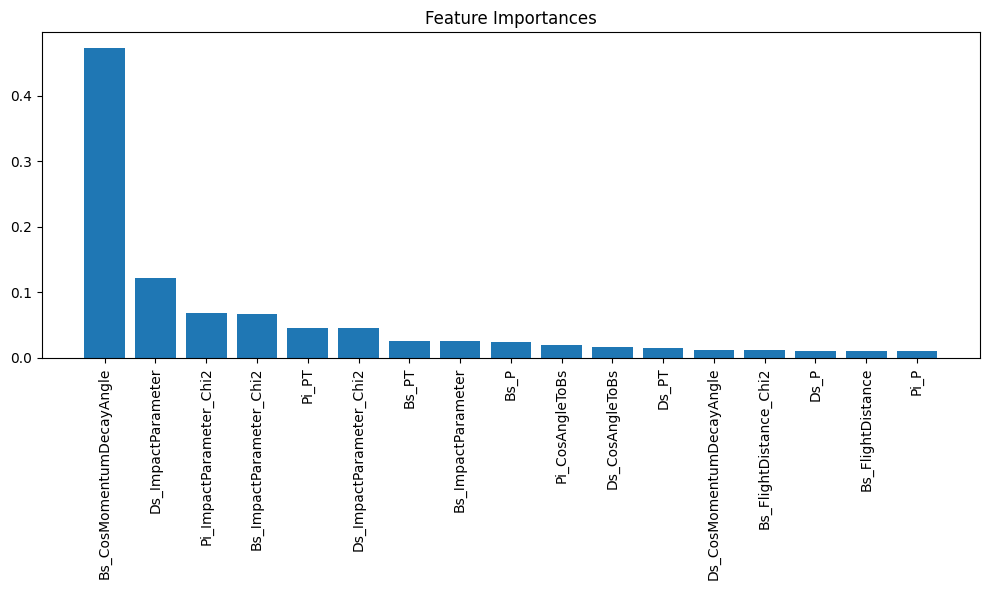

In [121]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(variables)), importance[indices], align="center")
plt.xticks(range(len(variables)), [variables[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig("feature_importances.png")

#### Simple-Model: Gaussian Signal + Exponential 

(100,)


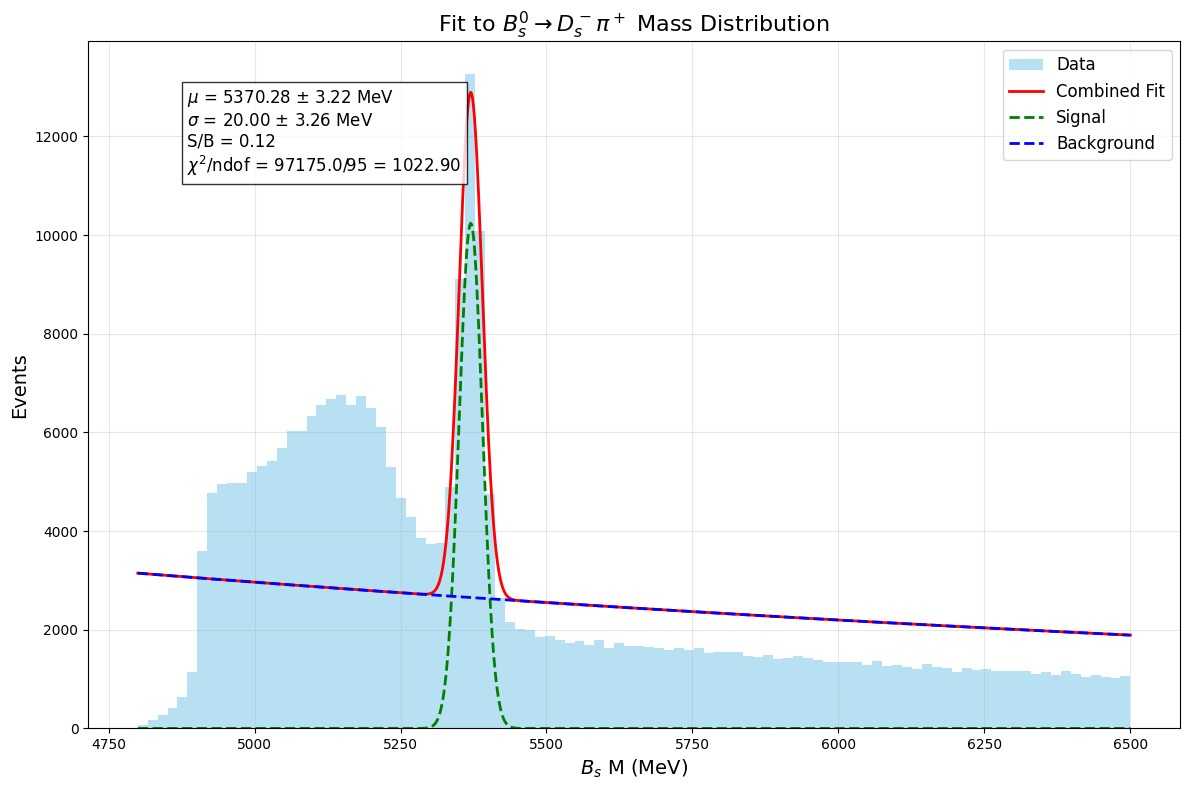

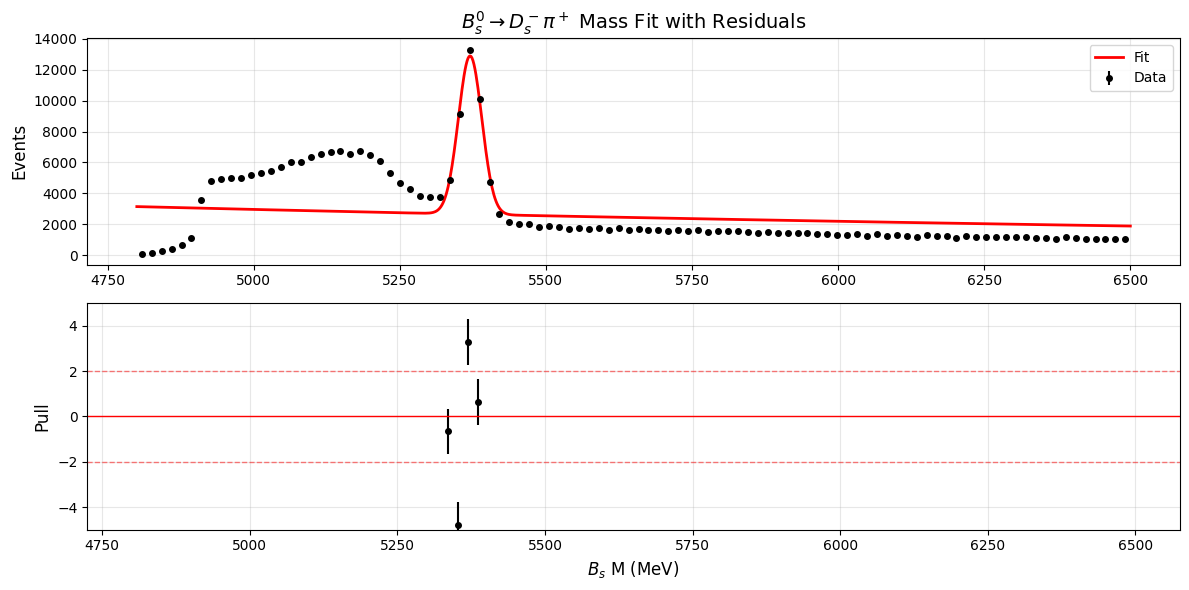

Fit results:
{'S_over_B': np.float64(0.12246580268420902),
 'bkg_exp_amp': np.float64(13266.9999999222),
 'bkg_exp_rate': np.float64(0.00029971638117104964),
 'chi2': np.float64(97175.03754593973),
 'chi2_per_ndof': np.float64(1022.8951320625235),
 'ndof': 95,
 'signal_amp': np.float64(10241.663932069128),
 'signal_error': np.float64(110322.17798333216),
 'signal_mu': np.float64(5370.28087688762),
 'signal_sigma': np.float64(20.00000000000001)}


In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from pprint import pprint

def fit_mass_distribution(df, mass_range=(5300, 5500), n_bins=100):
    
    # Create histogram of mass
    hist, bin_edges = np.histogram(df['Bs_M'], bins=n_bins, range=mass_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    
    print(bin_centers.shape)

    # Define fit functions
    def gaussian(x, amp, mu, sigma):
        """Gaussian function for signal peak"""
        return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)
    
    def exponential(x, a, b):
        """Exponential function for combinatorial background"""
        return a * np.exp(-b * x)
    
    def combined_model(x, amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b,):
        """Combined model with Gaussian signal and background components"""
        return gaussian(x, amp_gauss, mu_gauss, sigma_gauss) + exponential(x, exp_a, exp_b)
    
    
    p0 = [2, 5370.0, 25.0, np.max(hist) * 0.001, 0.0001]

    bounds = (
        [0, 5363, 20, 0, 0.00001], ## lower-bounds
        [np.sum(hist), 5375, 500, np.max(hist), 0.01] ## upper bounds
    )

    # Perform the fit with robust error handling
    try:
        popt, pcov = opt.curve_fit(combined_model, bin_centers, hist, p0=p0, bounds=bounds, 
                                  method='trf', maxfev=10000)
        
        # Extract parameters
        amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b = popt
        
        # Calculate errors
        perr = np.sqrt(np.diag(pcov))
        
        # Calculate individual components
        signal = gaussian(bin_centers, amp_gauss, mu_gauss, sigma_gauss)
        background_exp = exponential(bin_centers, exp_a, exp_b)
        background = background_exp
        
        # Calculate event counts (integrate components)
        total_signal = np.sum(signal) * bin_width ## integration/summation = #counts per bin_center * bin_width
        total_background = np.sum(background) * bin_width
        
        # Calculate signal error using error propagation
        # For a Gaussian: Integral = amp * sigma * sqrt(2π)
        signal_error = total_signal * np.sqrt((perr[0]/amp_gauss)**2 + (perr[2]/sigma_gauss)**2)
        
        # Goodness of fit metrics
        expected = combined_model(bin_centers, *popt)
        residuals = hist - expected
        chi2_val = np.sum((residuals)**2 / np.maximum(expected, 1))  # Avoid division by zero
        ndof = len(bin_centers) - len(popt)
        
        # Plot the results
        plt.figure(figsize=(12, 8))
        
        # Plot data histogram
        plt.hist(df['Bs_M'], bins=n_bins, range=mass_range, alpha=0.6, 
                label='Data', color='skyblue')
        
        # Generate smooth curves for plotting
        x_fit = np.linspace(mass_range[0], mass_range[1], 1000)
        y_fit = combined_model(x_fit, *popt) 
        y_signal = gaussian(x_fit, amp_gauss, mu_gauss, sigma_gauss) 
        y_background = exponential(x_fit, exp_a, exp_b) 
        
        # Plot fit components
        plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Combined Fit')
        plt.plot(x_fit, y_signal, 'g--', linewidth=2, label='Signal')
        plt.plot(x_fit, y_background, 'b--', linewidth=2, label='Background')
        
        # Add labels and information
        plt.xlabel('$B_s$ M (MeV)', fontsize=14)
        plt.ylabel(f'Events', fontsize=14)
        plt.title(r'Fit to $B_s^0 \to D_s^- \pi^+$ Mass Distribution', fontsize=16)
        
        # Add text box with fit results
        plt.text(mass_range[0] + (mass_range[1]-mass_range[0])*0.05, 
                 0.85 * max(hist), 
                 f'$\mu$ = {mu_gauss:.2f} ± {perr[1]:.2f} MeV\n'
                 f'$\sigma$ = {sigma_gauss:.2f} ± {perr[2]:.2f} MeV\n'
                 f'S/B = {total_signal/total_background:.2f}\n'
                 f'$\chi^2$/ndof = {chi2_val:.1f}/{ndof} = {chi2_val/ndof:.2f}',
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        # plt.savefig("improved_mass_fit.png", dpi=300)
        
        # Create a better visualization of the fit quality
        plt.figure(figsize=(12, 6))
        
        # Top panel: data and fit
        plt.subplot(211)
        plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='o', markersize=4, 
                     color='black', label='Data')
        plt.plot(x_fit, (y_fit * bin_width) / bin_width, 'r-', linewidth=2, label='Fit')
        plt.ylabel('Events', fontsize=12)
        plt.legend(fontsize=10, loc='upper right')
        plt.grid(alpha=0.3)
        plt.title(r'$B_s^0 \to D_s^- \pi^+$ Mass Fit with Residuals', fontsize=14)
        
        # Bottom panel: residuals
        plt.subplot(212)
        plt.errorbar(bin_centers, residuals / np.sqrt(np.maximum(hist, 1)), 
                     yerr=np.ones_like(hist), fmt='o', markersize=4, color='black')
        plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
        plt.axhline(y=2, color='r', linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=-2, color='r', linestyle='--', linewidth=1, alpha=0.5)
        plt.xlabel('$B_s$ M (MeV)', fontsize=12)
        plt.ylabel('Pull', fontsize=12)
        plt.ylim(-5, 5)
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        # plt.savefig("mass_fit_residuals.png", dpi=300)
        plt.show()

        return {
            'signal_amp': amp_gauss,
            'signal_mu': mu_gauss,
            'signal_sigma': sigma_gauss,
            'signal_error': signal_error,
            'bkg_exp_amp': exp_a,
            'bkg_exp_rate': exp_b,
            'S_over_B': total_signal / total_background,
            'chi2': chi2_val,
            'ndof': ndof,
            'chi2_per_ndof': chi2_val/ndof
        }
    
    except Exception as e:
        print(f"Fit failed with error: {e}")
        # Plot raw data if fit fails
        plt.figure(figsize=(10, 8))
        plt.hist(df['Bs_M'], bins=n_bins, range=mass_range, color='skyblue')
        plt.xlabel('$B_s$ M (MeV)', fontsize=14)
        plt.ylabel(f'Events', fontsize=14)
        plt.title(r'$B_s^0 \to D_s^- \pi^+$ Mass Distribution (Fit Failed)', fontsize=16)
        plt.savefig("failed_mass_fit.png", dpi=300)
        return {'error': str(e)}

# Example usage
fit_results = fit_mass_distribution(data_df, mass_range=(4800, 6500), n_bins=100)
print("Fit results:")
pprint(fit_results)

In [124]:
# Function to calculate S/sqrt(S+B) for different BDT score cuts
def calculate_fom(df, cut_value, mass_range=(5300, 5500)):
    # Apply BDT cut
    df_cut = df[df['bdt_score'] > cut_value]
    
    if len(df_cut) < 100:  # Not enough events for a reasonable fit
        return 0, 0, 0
    
    # Create histogram of mass
    hist, bin_edges = np.histogram(df_cut['Bs_M'], bins=30, range=mass_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Define fit functions
    def gaussian(x, amp, mu, sigma):
        """Gaussian function for signal peak"""
        return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)
    
    def exponential(x, a, b):
        """Exponential function for combinatorial background"""
        return a * np.exp(-b * x)
    
    def combined_model(x, amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b):
        """Combined model with Gaussian signal and background components"""
        return gaussian(x, amp_gauss, mu_gauss, sigma_gauss) + exponential(x, exp_a, exp_b)
    
    p0 = [2, 5370.0, 25.0, np.max(hist) * 0.001, 0.0001]

    bounds = (
        [0, 5363, 20, 0, 0.00001], ## lower-bounds
        [np.sum(hist), 5375, 500, np.max(hist), 0.01] ## upper bounds
    )

    # Perform the fit with robust error handling  
    try:
        # Fit
        popt, _ = opt.curve_fit(combined_model, bin_centers, hist, method='trf', p0=p0, bounds=bounds)
        
        # Extract parameters
        amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b = popt
        
        # Calculate signal and background in ±3σ region
        signal_region = (mu_gauss - 3*sigma_gauss, mu_gauss + 3*sigma_gauss)
        x_signal_region = np.linspace(signal_region[0], signal_region[1], 1000)
        bin_width_sr = (signal_region[1] - signal_region[0]) / len(x_signal_region)
        
        signal_component = gaussian(x_signal_region, amp_gauss, mu_gauss, sigma_gauss)

        background_exp = exponential(bin_centers, exp_a, exp_b)
        background_component = background_exp
        
        # Integrate to get event counts in signal region
        S = np.sum(signal_component) * bin_width_sr
        B = np.sum(background_component) * bin_width_sr
        
        # Calculate Figure of Merit: S/sqrt(S+B)
        fom = S / np.sqrt(S + B) if (S + B) > 0 else 0
        
        return fom, S, B
    
    except:
        return 0, 0, 0

### NEED: How is Optimal Cut actually defined?

Cut: 0.00, FOM: 457.38, S: 212395.8, B: 3246.0, S/B: 65.43
Cut: 0.05, FOM: 458.38, S: 211644.5, B: 1547.2, S/B: 136.79
Cut: 0.09, FOM: 457.20, S: 210381.4, B: 1359.1, S/B: 154.80
Cut: 0.14, FOM: 456.80, S: 209910.0, B: 1252.1, S/B: 167.64
Cut: 0.19, FOM: 456.14, S: 209236.2, B: 1181.9, S/B: 177.03
Cut: 0.24, FOM: 455.65, S: 208742.3, B: 1129.3, S/B: 184.85
Cut: 0.28, FOM: 454.90, S: 208015.8, B: 1090.5, S/B: 190.75
Cut: 0.33, FOM: 454.33, S: 207458.5, B: 1051.7, S/B: 197.26
Cut: 0.38, FOM: 453.61, S: 206774.1, B: 1020.8, S/B: 202.56
Cut: 0.43, FOM: 484.89, S: 235121.5, B: 0.0, S/B: 22731336895391330339913728.00
Cut: 0.47, FOM: 483.17, S: 233454.8, B: 0.0, S/B: 48867052881041547264.00
Cut: 0.52, FOM: 451.28, S: 204589.7, B: 942.6, S/B: 217.04
Cut: 0.57, FOM: 450.59, S: 203945.7, B: 920.8, S/B: 221.48
Cut: 0.62, FOM: 449.74, S: 203161.7, B: 897.4, S/B: 226.38
Cut: 0.66, FOM: 448.55, S: 202071.4, B: 874.6, S/B: 231.05
Cut: 0.71, FOM: 447.10, S: 200743.3, B: 848.4, S/B: 236.60
Cut: 0.76, F

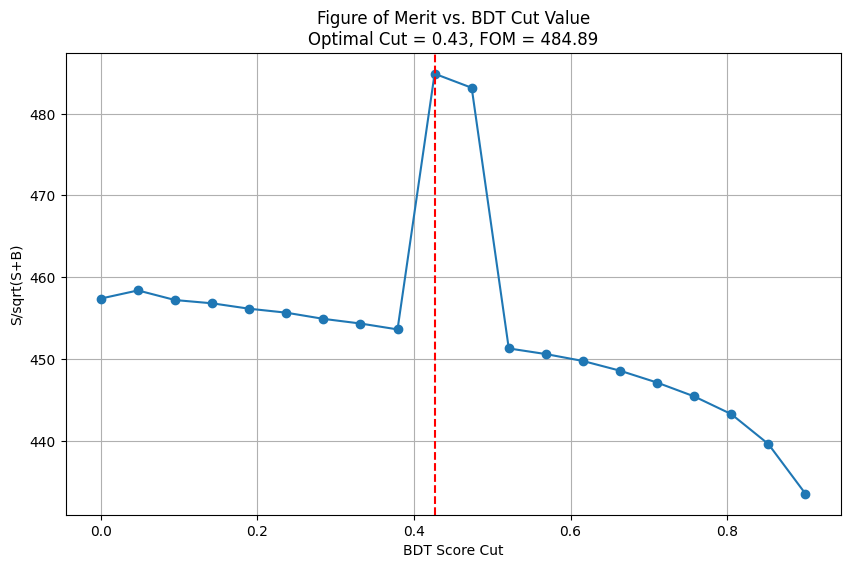

In [125]:
# Optimize the BDT cut
cut_values = np.linspace(0, 0.9, 20)
fom_values = []
s_values = []
b_values = []

for cut in cut_values:
    fom, s, b = calculate_fom(data_df, cut)
    fom_values.append(fom)
    s_values.append(s)
    b_values.append(b)
    print(f"Cut: {cut:.2f}, FOM: {fom:.2f}, S: {s:.1f}, B: {b:.1f}, S/B: {s/b if b > 0 else 0:.2f}")

# Find the optimal cut
best_idx = np.argmax(fom_values)
best_cut = cut_values[best_idx]
best_fom = fom_values[best_idx]
best_s = s_values[best_idx]
best_b = b_values[best_idx]

# Plot FOM vs. cut value
plt.figure(figsize=(10, 6))
plt.plot(cut_values, fom_values, 'o-')
plt.xlabel('BDT Score Cut')
plt.ylabel('S/sqrt(S+B)')
plt.title(f'Figure of Merit vs. BDT Cut Value\nOptimal Cut = {best_cut:.2f}, FOM = {best_fom:.2f}')
plt.axvline(x=best_cut, color='r', linestyle='--')
plt.grid(True)
plt.savefig("fom_vs_cut.png")

# Apply the optimal cut and perform a final fit
data_df_cut = data_df[data_df['bdt_score'] > best_cut]

In [131]:
# Function for final fit with optimal cut
def final_fit(df, mass_range=(5300, 5500)):
    # Create histogram of mass
    hist, bin_edges = np.histogram(df['Bs_M'], bins=40, range=mass_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Define fit functions
    def gaussian(x, amp, mu, sigma):
        """Gaussian function for signal peak"""
        return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)
    
    def exponential(x, a, b):
        """Exponential function for combinatorial background"""
        return a * np.exp(-b * x)
    
    def combined_model(x, amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b):
        """Combined model with Gaussian signal and background components"""
        return gaussian(x, amp_gauss, mu_gauss, sigma_gauss) + exponential(x, exp_a, exp_b)
    
    
    p0 = [2, 5370.0, 25.0, np.max(hist) * 0.001, 0.0001]

    bounds = (
        [0, 5363, 20, 0, 0.00001], ## lower-bounds
        [np.sum(hist), 5375, 500, np.max(hist), 0.01] ## upper bounds
    )
    
    # Fit
    popt, pcov = opt.curve_fit(combined_model, bin_centers, hist, method='trf', p0=p0, bounds=bounds)
    
    # Extract parameters
    amp_gauss, mu_gauss, sigma_gauss, exp_a, exp_b = popt
    
    perr = np.sqrt(np.diag(pcov))
    
    # Calculate signal and background in ±3σ region
    signal_region = (mu_gauss - 3*sigma_gauss, mu_gauss + 3*sigma_gauss)
    
    # Count events in the signal region
    mask_sr = (df['Bs_M'] >= signal_region[0]) & (df['Bs_M'] <= signal_region[1])
    events_in_sr = len(df[mask_sr])
    
    # Fit components in signal region
    x_signal_region = np.linspace(signal_region[0], signal_region[1], 1000)
    bin_width_sr = (signal_region[1] - signal_region[0]) / len(x_signal_region)
    
    signal_component = gaussian(x_signal_region, amp_gauss, mu_gauss, sigma_gauss)
    
    background_exp = exponential(bin_centers, exp_a, exp_b)
    background_component = background_exp
        
    # Integrate to get event counts in signal region
    S = np.sum(signal_component) * bin_width_sr
    B = np.sum(background_component) * bin_width_sr
    
    # Calculate S/B ratio
    s_over_b = S / B if B > 0 else float('inf')
    
    # Goodness of fit
    expected = combined_model(bin_centers, *popt)
    chi2_val = np.sum((hist - expected)**2 / expected)
    ndof = len(bin_centers) - len(popt)
    
    # Plot the fit
    plt.figure(figsize=(12, 9))
    plt.hist(df['Bs_M'], bins=40, range=mass_range, alpha=0.6, label='Data')
    
    x_fit = np.linspace(mass_range[0], mass_range[1], 1000)
    plt.plot(x_fit, combined_model(x_fit, *popt), 'r-', label='Combined Fit')
    plt.plot(x_fit, gaussian(x_fit, amp_gauss, mu_gauss, sigma_gauss), 'g--', label='Signal')
    
    background_exp_fit = exponential(x_fit, exp_a, exp_b)
    background_component_fit = background_exp_fit

    plt.plot(x_fit, background_component_fit, 'b--', label='Background')
    
    # Highlight signal region
    plt.axvspan(signal_region[0], signal_region[1], alpha=0.3, color='yellow', label='±3σ Region')
    
    plt.xlabel('B_M (MeV)')
    plt.ylabel('Events')
    plt.title(r'Fit to $B_s^0 \to D_s^- \pi^+$ Mass Distribution with BDT Cut > {:.2f}'.format(best_cut))
    plt.legend()
    
    plt.text(mass_range[0] + 10, 0.8 * max(hist), 
             f'$\mu$ = {mu_gauss:.2f} ± {perr[1]:.2f} MeV\n'
             f'$\sigma$ = {sigma_gauss:.2f} ± {perr[2]:.2f} MeV\n'
             f'S/B in ±3σ = {s_over_b:.2f}\n'
             f'$\chi^2$/ndof = {chi2_val:.1f}/{ndof} = {chi2_val/ndof:.2f}')
    
    plt.tight_layout()
    plt.savefig("final_mass_fit.png")
    
    return {
        'mu': mu_gauss,
        'sigma': sigma_gauss,
        'signal': S,
        'background': B,
        'S_over_B': s_over_b,
        'events_in_sr': events_in_sr
    }

Final fit results after BDT cut: {'mu': np.float64(5370.321090850164), 'sigma': np.float64(20.000000000000004), 'signal': np.float64(155033.4719042999), 'background': np.float64(978.4037527820766), 'S_over_B': np.float64(158.4555164097281), 'events_in_sr': 36265}
Signal-to-background ratio in ±3σ region: 158.46

SUMMARY OF RESULTS:
Initial signal-to-background ratio: 0.12
Optimal BDT cut: 0.43
Final signal-to-background ratio: 158.46
Improvement factor: 1293.88x


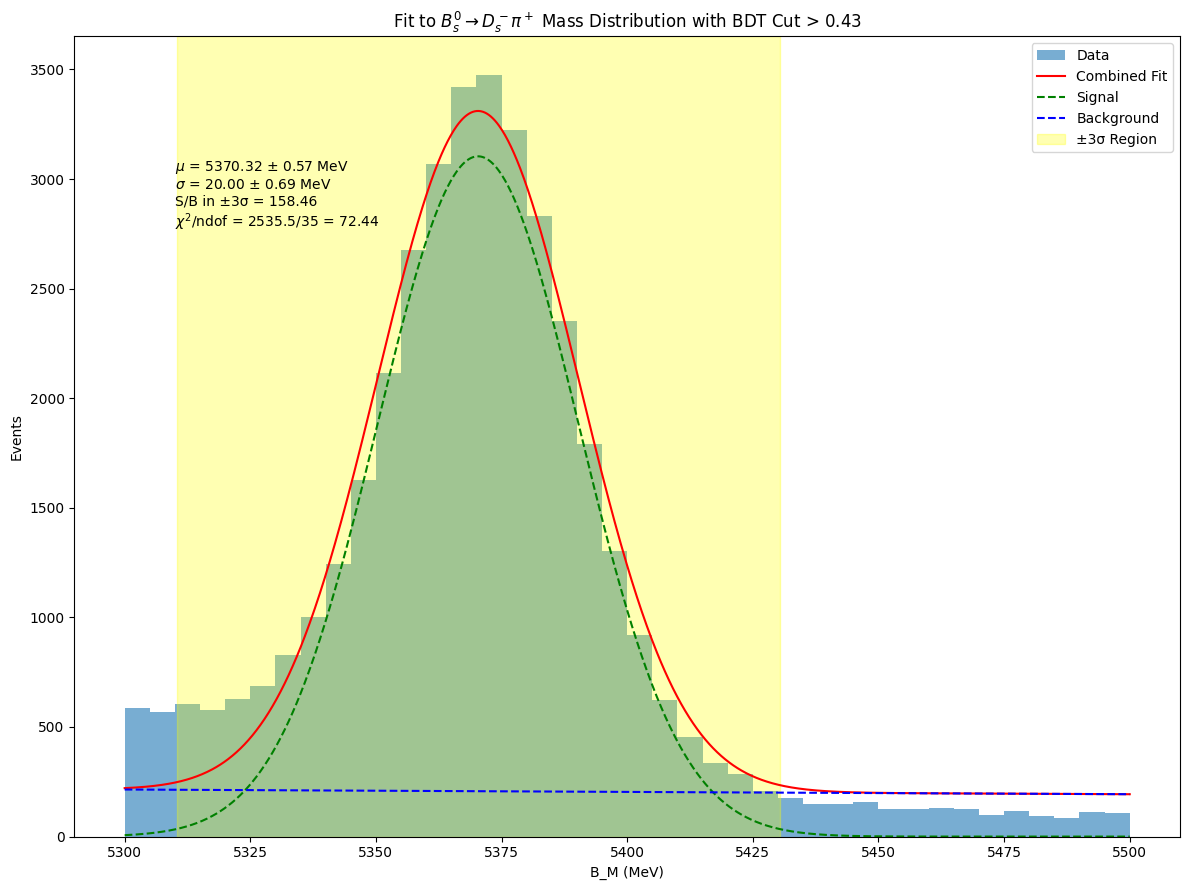

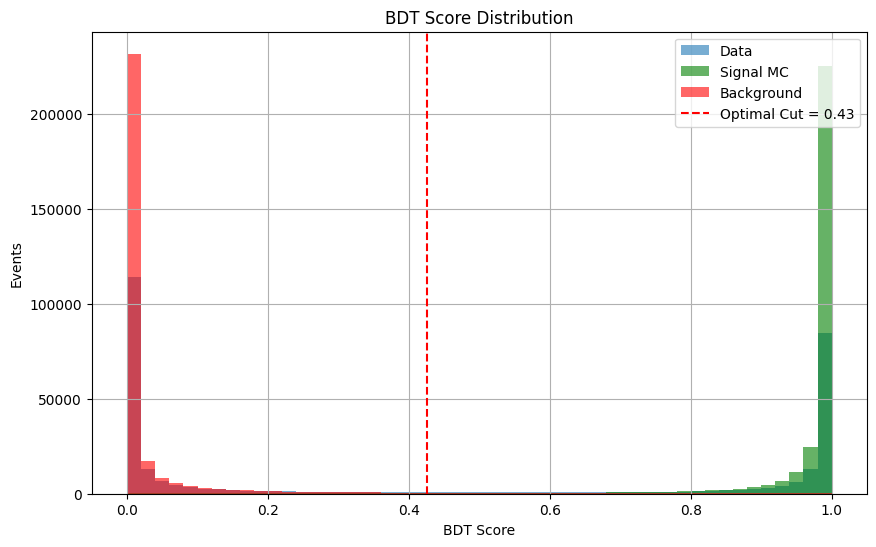

In [132]:
# Perform final fit with optimal cut
final_results = final_fit(data_df_cut)
print("Final fit results after BDT cut:", final_results)
print(f"Signal-to-background ratio in ±3σ region: {final_results['S_over_B']:.2f}")

# Plot BDT score distribution for signal and background
plt.figure(figsize=(10, 6))
plt.hist(data_predictions, bins=50, range=(0, 1), alpha=0.6, label='Data')

# Overlay signal and background distributions from MC
sig_pred = model.predict_proba(signal_df[variables])[:, 1]
bkg_pred = model.predict_proba(background_df[variables])[:, 1]

plt.hist(sig_pred, bins=50, range=(0, 1), alpha=0.6, label='Signal MC', color='green', 
         weights=np.ones_like(sig_pred)*len(data_predictions)/len(sig_pred))
plt.hist(bkg_pred, bins=50, range=(0, 1), alpha=0.6, label='Background', color='red',
         weights=np.ones_like(bkg_pred)*len(data_predictions)/len(bkg_pred))

plt.axvline(x=best_cut, color='r', linestyle='--', label=f'Optimal Cut = {best_cut:.2f}')
plt.xlabel('BDT Score')
plt.ylabel('Events')
plt.title('BDT Score Distribution')
plt.legend()
plt.grid(True)
plt.savefig("bdt_score_distribution.png")

# Summary of results
print("\nSUMMARY OF RESULTS:")
print(f"Initial signal-to-background ratio: {fit_results['S_over_B']:.2f}")
print(f"Optimal BDT cut: {best_cut:.2f}")
print(f"Final signal-to-background ratio: {final_results['S_over_B']:.2f}")
print(f"Improvement factor: {final_results['S_over_B']/fit_results['S_over_B']:.2f}x")